# End of sentence recognition

read prepared file

In [55]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

df = pd.read_csv('lucene_corpus.zip', compression='zip')
df.replace(['False', 'True'], [0, 1], inplace=True)

Earlier, I prepared a file with lists of 3-grams (w-1 w {EOS} w+1) and words which were the end of sentence (EOS).

In [2]:
counts = pd.read_csv('eos_ngrams.zip', header=None, sep='\t', compression='zip')

# 3-grams (as is and lemmas)
end_threegrams_count = counts[0].value_counts().to_dict()
end_threegrams_lem_count = counts[1].value_counts().to_dict()
threegrams_count = df['threegrams'].value_counts().to_dict()
threegrams_lem_count = df['threegrams_lemma'].value_counts().to_dict()

# 1-grams (as is and lemmas)
end_word_count = counts[2].value_counts().to_dict()
end_word_lem_count = counts[3].value_counts().to_dict()
word_count = df['n_token_text'].value_counts().to_dict()
word_lem_count = df['n_lemma'].value_counts().to_dict()

In [3]:
df.label.value_counts()

False    251176
True      10544
Name: label, dtype: int64

The df is very unbalanced. Let's try to decrease it.
First, calculate the frequency how often such words and n-grams are in the EOS.

In [4]:
end_3_freq = {k: end_threegrams_count.get(k, 0.0)/v for k, v in threegrams_count.items()}
end_3_freq_lem = {k: end_threegrams_lem_count.get(k, 0.0)/v for k, v in threegrams_lem_count.items()}
end_1_freq = {k: end_word_count.get(k, 0.0)/v for k, v in word_count.items()}
end_1_freq_lem = {k: end_word_lem_count.get(k, 0.0)/v for k, v in word_lem_count.items()}

In [5]:
df['end_3_freq'] = df['threegrams'].apply(lambda x: end_3_freq.get(x, 0.0))
df['end_3_freq_lem'] = df['threegrams_lemma'].apply(lambda x: end_3_freq_lem.get(x, 0.0))
df['end_1_freq'] = df['n_token_text'].apply(lambda x: end_1_freq.get(x, 0.0))
df['end_1_freq_lem'] = df['n_lemma'].apply(lambda x: end_1_freq_lem.get(x, 0.0))

I think that the words that are not the EOS can be excluded from the df to make it more balanced.

In the testing for the words that are not in the possible EOS list the coef will be a minimal value 0.0001

In [6]:
df_filtered = df[(df['end_1_freq'] > 0)]

In [7]:
df_filtered.label.value_counts()

False    155219
True      10541
Name: label, dtype: int64

In [8]:
pos_vect = CountVectorizer().fit(df['n_pos'])

Prepare features for POS values for word and it's neighbors.
#TODO: try to transform it to n-grams and frequenices in future

In [9]:
pos_n_df = pd.DataFrame(pos_vect.transform(df_filtered['n_pos']).todense(),
                      columns=['n_{}'.format(x) for x in pos_vect.get_feature_names()], index=df_filtered.index)

In [10]:
pos_na1_df = pd.DataFrame(pos_vect.transform(df_filtered['na1_pos'].fillna('')).todense(),
                      columns=['na1_{}'.format(x) for x in pos_vect.get_feature_names()], index=df_filtered.index)

In [11]:
pos_nb1_df = pd.DataFrame(pos_vect.transform(df_filtered['nb1_n_lemma'].fillna('')).todense(),
                      columns=['nb1_{}'.format(x) for x in pos_vect.get_feature_names()], index=df_filtered.index)

In [12]:
model_columns = ['n_is_aplpha', 'n_is_digit', 'n_is_lower', 'n_is_punct', 'n_is_title',
                 'na1_is_aplpha', 'na1_is_digit', 'na1_is_lower', 'na1_is_punct', 'na1_is_title',
                 'na2_is_aplpha', 'na2_is_digit', 'na2_is_lower', 'na2_is_punct', 'na2_is_title',
                 'nb1_n_is_aplpha', 'nb1_n_is_digit', 'nb1_n_is_lower', 'nb1_n_is_punct', 'nb1_n_is_title',
                 'nb2_n_is_aplpha', 'nb2_n_is_digit', 'nb2_n_is_lower', 'nb2_n_is_punct', 'nb2_n_is_title',
                 'end_3_freq', 'end_3_freq_lem', 'end_1_freq', 'end_1_freq_lem']

In [13]:
df_filtered = df_filtered.drop((df_filtered.loc[~df_filtered['nb1_n_is_aplpha'].fillna(False).isin({False, True})].index))
X_train = pd.concat([df_filtered[model_columns], pos_n_df, pos_na1_df, pos_nb1_df], axis=1, join="inner")

## Train

In [14]:
X_train.shape

(165758, 74)

Fill missing values: for is_alpha make it's True, for other - False

In [15]:
for col in model_columns:
    if 'is_aplpha' in col:
        X_train[col].fillna(True, inplace=True)

X_train.fillna(False, inplace=True)

#### Prepare Logistic Regression model

In [16]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score

clf = LogisticRegressionCV(scoring='f1', class_weight='balanced')
clf.fit(X_train, df_filtered['label'])

LogisticRegressionCV(Cs=10, class_weight='balanced', cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring='f1', solver='lbfgs', tol=0.0001, verbose=0)

10 most valueble features in the model

In [17]:
import numpy as np

feature_names = X_train.columns

top = np.argsort([abs(x) for x in clf.coef_[0]])
reversed_top = top[::-1]
[(feature_names[j], clf.coef_[0][j]) for j in reversed_top[:10]]

[('end_3_freq', 4.4377614511936265),
 ('end_3_freq_lem', 3.7366641904252536),
 ('na1_is_lower', -1.1025510436448467),
 ('na1_is_title', 1.0753745478482482),
 ('end_1_freq', 0.63749616768840178),
 ('end_1_freq_lem', 0.52567193036170212),
 ('n_adp', -0.39998008333929697),
 ('na1_pron', 0.32863716528727172),
 ('na1_propn', -0.28031939478103585),
 ('n_noun', 0.24423490902181796)]

Useless features of the model

In [18]:
[(feature_names[j], clf.coef_[0][j]) for j in top if abs(clf.coef_[0][j]) < 0.001 ]

[('nb1_cconj', 0.0),
 ('nb1_sym', 0.0),
 ('na1_space', 0.0),
 ('nb1_punct', 0.0),
 ('nb1_adj', 0.0),
 ('nb1_propn', 0.0),
 ('nb1_adp', 0.0),
 ('nb1_adv', 0.0),
 ('n_space', 0.0),
 ('nb1_det', 0.0),
 ('nb1_intj', 0.0),
 ('nb1_verb', -4.5396897676403612e-05),
 ('nb1_num', -5.5024003002861259e-05),
 ('nb1_noun', -0.00013931893091475867),
 ('nb1_space', -0.00050343879875282477),
 ('n_det', 0.00066209940607732842)]

## Test

Load data after pre-processing the test data

In [19]:
df_test = pd.read_csv('test_data.zip', compression='zip')
df_test.replace(['False', 'True'], [0, 1], inplace=True)

Add features of term frequency

In [20]:
df_test['end_3_freq'] = df_test['threegrams'].apply(lambda x: end_3_freq.get(x, 0.0))
df_test['end_3_freq_lem'] = df_test['threegrams_lemma'].apply(lambda x: end_3_freq_lem.get(x, 0.0))
df_test['end_1_freq'] = df_test['n_token_text'].apply(lambda x: end_1_freq.get(x, 0.0))
df_test['end_1_freq_lem'] = df_test['n_lemma'].apply(lambda x: end_1_freq_lem.get(x, 0.0))

In [21]:
df_test.label.value_counts()

False    4542
True      155
Name: label, dtype: int64

In [22]:
pos_n_df_test = pd.DataFrame(pos_vect.transform(df_test['n_pos']).todense(),
                      columns=['n_{}'.format(x) for x in pos_vect.get_feature_names()], index=df_test.index)

In [23]:
pos_na1_df_test = pd.DataFrame(pos_vect.transform(df_test['na1_pos'].fillna('')).todense(),
                      columns=['na1_{}'.format(x) for x in pos_vect.get_feature_names()], index=df_test.index)

In [24]:
pos_nb1_df_test = pd.DataFrame(pos_vect.transform(df_test['nb1_n_lemma'].fillna('')).todense(),
                      columns=['nb1_{}'.format(x) for x in pos_vect.get_feature_names()], index=df_test.index)

In [25]:
X_test = pd.concat([df_test[model_columns], pos_n_df_test, pos_na1_df_test, pos_nb1_df_test], axis=1, join="inner")

In [26]:
for col in model_columns:
    if 'is_aplpha' in col:
        X_test[col].fillna(True, inplace=True)

X_test.fillna(False, inplace=True)

### Evaluation

Custom threshold

In [31]:
pred_df = pd.DataFrame(clf.predict_proba(X_test))
y_test = df_test['label']

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, pred_df[1])
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

Area under the ROC curve : 0.769858


In [34]:
import matplotlib.pyplot as plt
plt.figure()
##Adding the ROC
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve')
##Random FPR and TPR
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
##Title and label
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

<Figure size 640x480 with 1 Axes>

In [35]:
####################################
# The optimal cut off would be where tpr is high and fpr is low
# tpr - (1-fpr) is zero or near to zero is the optimal cut off point
####################################
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
roc.loc[(roc.tf-0).abs().argsort()[:1]]

,1-fpr,fpr,tf,thresholds,tpr
288,0.705636,0.294364,0.016944,0.006481,0.722581


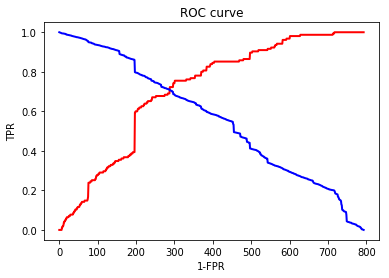

In [36]:
plt.figure()
plt.plot(roc['tpr'], color='red', lw=2)
plt.plot(roc['1-fpr'], color='blue', lw=2)
plt.xlabel('1-FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

So the threshold for log probability is 0.006481

In [46]:
threshold = 0.0065
preds = pred_df[1] > threshold

In [47]:
preds.value_counts()

False    3294
True     1403
Name: 1, dtype: int64

In [48]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_curve, auc

print('Accuracy:', accuracy_score(y_test, preds))
print()
print('Precision weighted:', precision_score(y_test, preds, average='weighted'))
print('Recall weighted:', recall_score(y_test, preds, average='weighted'))
print('F1 score weighted:', f1_score(y_test, preds, average='weighted'))

Accuracy: 0.713434106877

Precision weighted: 0.955108783708
Recall weighted: 0.713434106877
F1 score weighted: 0.805387661032


In [49]:
conf_matrix = confusion_matrix(y_test, preds)
conf_matrix_sents = pd.DataFrame(conf_matrix)

In [50]:
conf_matrix_sents

,0,1
0,3245,1297
1,49,106


In [51]:
from sklearn.metrics import classification_report
print(classification_report(y_test, preds))

             precision    recall  f1-score   support

      False       0.99      0.71      0.83      4542
       True       0.08      0.68      0.14       155

avg / total       0.96      0.71      0.81      4697



model's threshold

In [52]:
y_pred = clf.predict(X_test)

In [53]:
conf_matrix_pred = confusion_matrix(y_test, y_pred)
conf_matrix_sents_pred = pd.DataFrame(conf_matrix_pred)

In [54]:
conf_matrix_sents_pred

,0,1
0,4542,0
1,155,0


### Conclusion

I think, that the result is very bad.

I think the reasons is not relevant train corpus: the scores on the train cross-validation is much more better.

Ways to improve:
<li> Add few more corpuses to train</li>
<li> Add 2-grams and 4-grams to the features</li>
<li> Redesign work with POS</li>
<li> Exclude usless features from the model</li>